# Introduction
Accurate and timely weather prediction can provide critical information for businesses in fields such as agriculture and transportation. This information can be used to make informed decisions and take necessary actions to mitigate potential risks. However, traditional weather forecasting methods can be limited in their accuracy and efficiency. They also require massive models which perform predictions using complex physical relationships and a large number of independent variables. By leveraging the power of deep learning techniques such as convolutional neural networks (CNNs), the accuracy of weather prediction can be improved and businesses can be equipped with more reliable and real time forecasts.

## Import required modules

In [3]:
# Use this cell to import all the required packages and methods

#Handling raw data files
import os 

# Working with numbers and data frames:
import numpy as np
import pandas as pd

# Visualizing data
from matplotlib import pyplot as plt
import seaborn as sns

# Utilities for handling images
from tensorflow.keras.utils import img_to_array,array_to_img,load_img

# Augmenting image data
from tensorflow import image


# Processing data
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split 

# Creating CNN models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten 

# Defining the Adam optimizer
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

## Load the data

In [5]:
# Define a function that loads images and their labels
def load_data(mainfolder = None):
    '''
    Loads the images from the main folder in a list and creates a list
    containing labels for the images

    Args:
        mainfolder: A string that describes the address of the parent data
            folder in the memory
    
    Returns:
        list_of_images: A list containing PIL Image instances for each image
        image_labels: A list containing their respective labels in the form 
            of a string
    '''
    # We get in the weather folder
    new_main_folder = f"weather/{mainfolder}"
    
    # We create two empty arrays for the images and the labels
    list_of_images,image_labels = [],[]

    ##### CODE HERE #####
    for type_folder in os.listdir(new_main_folder):
        type_folder_path = os.path.join(new_main_folder,type_folder)
        for file_name in os.listdir(type_folder_path):
            # We save the the image 
            image_path = os.path.join(type_folder_path,file_name)
            image = load_img(image_path)
            list_of_images.append(image)
            
            # We save the label
            label = type_folder_path.split("/")[-1]
            image_labels.append(label)       
    return list_of_images, image_labels

In [6]:
# Use this cell to load the training and testing data sets and store them in the appropriate variables

# Load the training data
X_train, y_train = load_data('train')

# Load the testing data
X_test, y_test = load_data('test')



## Explore the data

In [8]:
import matplotlib.image as mpimg

train_folder = 'weather/train'
test_folder = 'weather/test'

def print_images(folder):
  for type_folder in os.listdir(folder):
    print(f"image {type_folder}")
    images = os.listdir(os.path.join(folder,type_folder))
    image_name = np.random.choice(images)
    image_path = os.path.join(folder,type_folder,image_name)
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Training Dataset
image cloudy


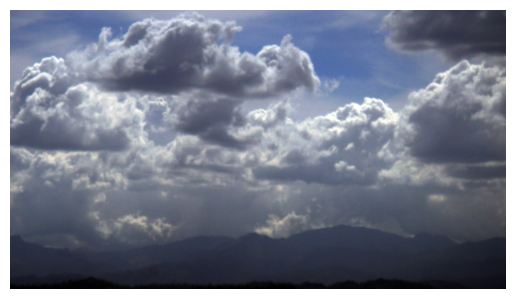

image sunny


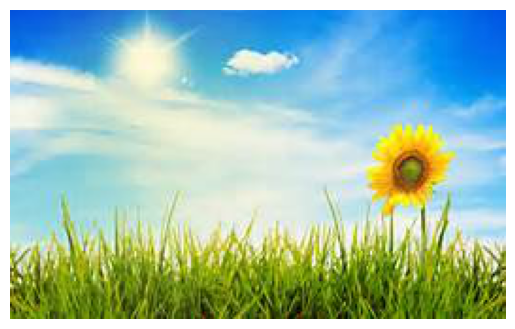

image rainy


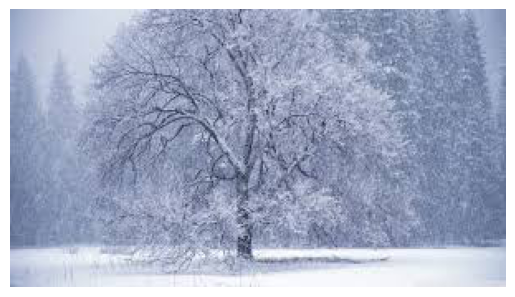

In [9]:
# Let's view few images from the trainig data set for each class
print("Training Dataset")
print_images(train_folder)

Testing Dataset
image cloudy


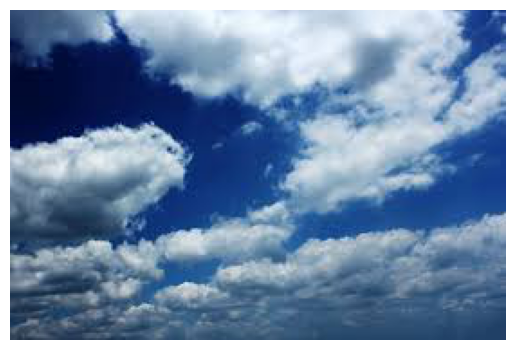

image sunny


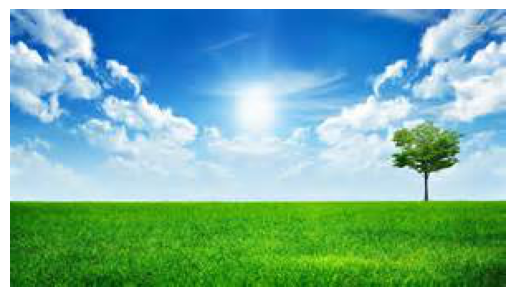

image rainy


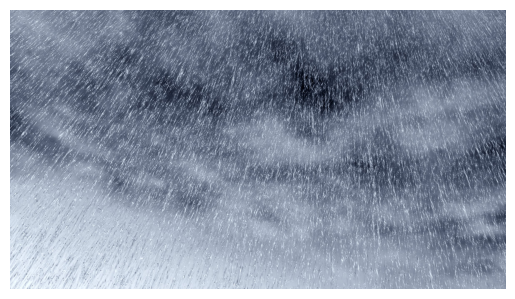

In [10]:
# Let's view few images from the testing data set for each class

print("Testing Dataset")
print_images(test_folder)

In [11]:
# Let's inspect the number of training and testing data points available

n_training = len(X_train)
n_testing = len(X_test)

print(f"There are {n_training} training data points")
print(f"There are {n_testing} testing data points")

There are 505 training data points
There are 45 testing data points


In [12]:

# Extract and store the total class count
n_classes = len(np.array(os.listdir('weather/test')))
print('Number of classes =', n_classes)

Number of classes = 3


In [13]:
# Let's inspect the number of training and testing data points available in each class

##### CODE HERE #####

# We are going to create a dataframe from 


unique_elements_train,count_train = np.unique(y_train,return_counts=True)
unique_elements_test,count_test = np.unique(y_test,return_counts=True)

print("Training Data")
for element, count in zip(unique_elements_train, count_train):
  print(f"There are {count} images which are classified {element}")

print('\n')

print("Testing Data")
for element, count in zip(unique_elements_test, count_test):
  print(f"There are {count} images which are classified {element}")
    

Training Data
There are 285 images which are classified cloudy
There are 70 images which are classified rainy
There are 150 images which are classified sunny


Testing Data
There are 15 images which are classified cloudy
There are 15 images which are classified rainy
There are 15 images which are classified sunny


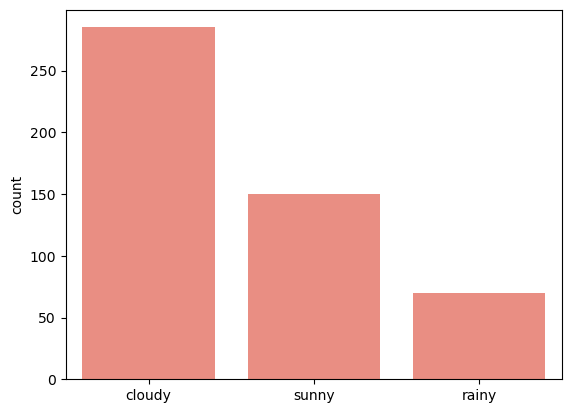

In [14]:
# Let's visualize the class balance in the training data set
sns.countplot(x=y_train,color="salmon")
plt.show()

# Stage 2 - Data Preparation

In [16]:
# Let's resize all the images to have the same dimension for the CNN model
# Let's find the smallest image dimension in the training and the testing data sets

def get_smallest_dimension(arr):
  min_width = float('inf')
  min_height = float('inf')
  for image in arr:
    width,height = image.size 
    min_width = min(min_width,width)
    min_height = min(min_height,height)
  return min(min_width,min_height)
    
minimum_dim_train = get_smallest_dimension(X_train)
minimum_dim_test = get_smallest_dimension(X_test)

print(minimum_dim_train)
print(minimum_dim_test)


111
160


In [17]:


# Let's define a function that resizes image dimensions
def resize_images(input_images= None, new_dims = None):
    '''
    Resizes all the images in a list to a square with its side given.

    Args:
        input_images: A list of images to be resized. Each input image 
            must be a PIL image.
        new_dims: An integer specifying the desired dimensions of the output 
            images. Each output image will have the same height and width.

    Returns:
        resized_images: A list of resized images. Each output image is a PIL 
            image with the specified dimensions.
    '''
    
    resized_images = []
  
    ##### CODE HERE #####
    for img in input_images:
        arr_img = img_to_array(img)
        resized_arr = image.resize(arr_img,new_dims)
        resized_img = array_to_img(resized_arr)
        resized_images.append(resized_img)
    return resized_images

In [18]:
# let's set the new dimensions for all images
new_image_dims = (64,64)

In [19]:
# Standardize the dimensions for all images in the training data set
X_train = resize_images(X_train,new_image_dims)

# Standardize the dimensions for all images in the testing data set
X_test = resize_images(X_test,new_image_dims)

In [20]:
# Let's define a function to show random images
def view_random_images(X_arr,y_arr,num_index):
  # We create a dataframe
  data_df = pd.DataFrame({'Image':X_arr,'Classification':y_arr})
  classifications = data_df['Classification'].unique()
  for classification in classifications:
    condition_df = data_df[data_df['Classification'] == classification]
    random_df = condition_df.sample(n=num_index)
    for index,row in random_df.iterrows():
      plt.imshow(row['Image'])
      plt.axis('off')
      plt.title(classification)# Optional: turn off axis
      plt.show()

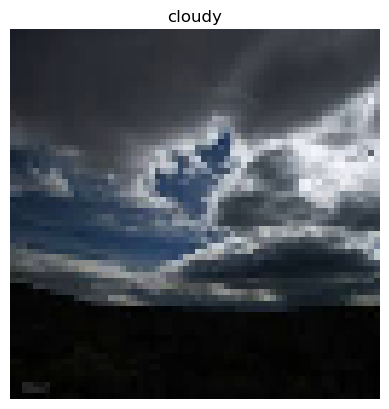

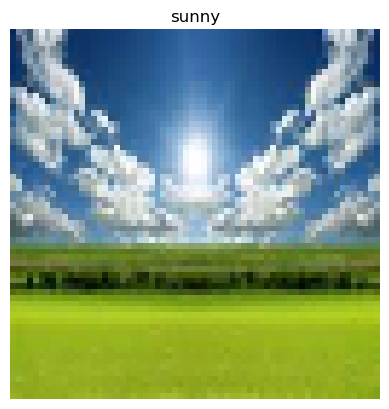

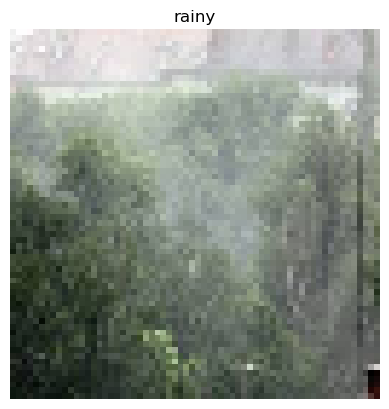

In [21]:
# Let's view few images from the training data set for each class

view_random_images(X_train,y_train,1)

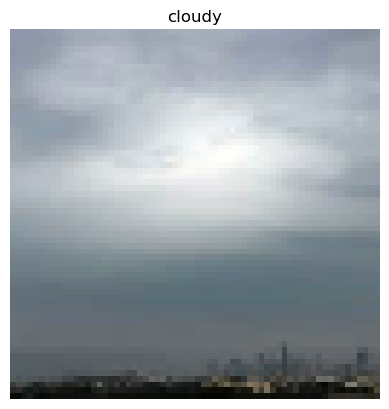

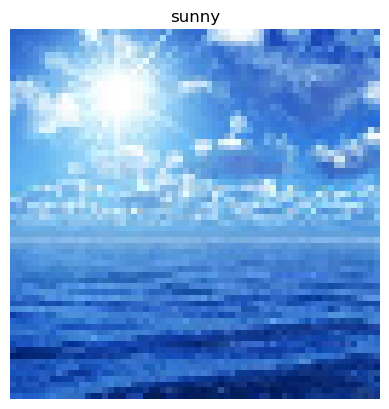

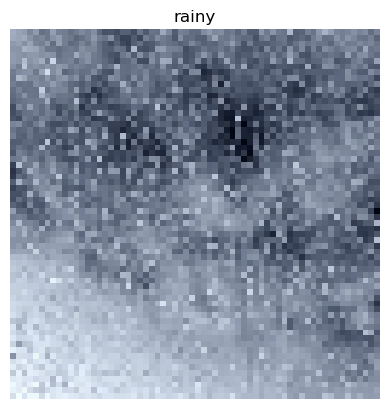

In [22]:
# Let's view a few images from the testing data set for each class

view_random_images(X_test,y_test,1)

In [23]:
# Let's store the resized images and labels for later use


X_pre_NN = X_train

# Store the labels for later use
y_pre_NN = y_train

## Prepare the data for feeding into CNN


In [25]:
# Let's convert the training and testing images into arrays


X_train = np.array([img_to_array(data) for data in X_train])
X_test = np.array([img_to_array(data) for data in X_test])



In [26]:
# Let's rescale the training and testing images from the range [0, 255] to [0, 1]

X_train = X_train.astype('float32') / 255 
X_test = X_test.astype('float32') / 255 

In [27]:
# Let's one-hot encode the labels in the training and testing data sets

y_train = to_categorical(LabelEncoder().fit_transform(y_train))
y_test = to_categorical(LabelEncoder().fit_transform(y_test))

In [28]:
# Let's store the input dimensions for the CNNs

# Store the input dimensions for the CNNs
inputdims = (X_train.shape[1],X_train.shape[2],X_train.shape[3])

# Simple Model
In this stage, we will build, train and evaluate a basic CNN model on the data and analyze its performance. We will build the model using a function. This will help us change the configuration of our model during execution. We will also test the performance of the performance of the model by training it multiple times and then judging the distribution of final accuracies and loss values.



In [30]:
# Let's define a function that creates and compiles a CNN

# Define a function that creates and compiles a CNN
def create_cnn(layers_config = None, learning_rate_value = None):
    '''
    Creates and compiles a convolutional neural network (CNN) with the specified layers configuration and learning rate.

    Args:
        layers_config: A list of strings specifying the configuration of each layer in the CNN. 
        learning_rate_value: A float specifying the learning rate to be used by the optimizer during training.
    
    Returns:
        cnn: A compiled CNN with the specified layers configuration and learning rate.
    '''

    cnn = Sequential()
    
    # Input layer
    cnn.add(Input(shape=inputdims))
    
    # Convolution layer 1 
    str_split1 = layers_config[0].split('_')

    cnn.add(
        Conv2D(
            filters = int(str_split1[1]),
            kernel_size = int(str_split1[2]),
            strides = ( int(str_split1[3]), int(str_split1[3]) )
        )
    ) 
    
    # Max Pooling 1 
    str_split2 = layers_config[1].split('_')
    cnn.add(
        MaxPooling2D(
            pool_size = ( int(str_split2[1]),int(str_split2[1]) ),
            strides = ( int(str_split2[2]),int(str_split2[2]) )
        )
    )

    # Convolution layer 2
    str_split3 = layers_config[2].split('_')
    cnn.add(
        Conv2D(
            input_shape = inputdims,
            filters = int(str_split3[1]),
            kernel_size = int(str_split3[2]),
            strides = ( int(str_split3[3]), int(str_split3[3]) )
        )
    )
    
    # Max Pooling 2 
    str_split4 = layers_config[1].split('_')
    cnn.add(
        MaxPooling2D(
            pool_size = ( int(str_split4[1]),int(str_split4[1]) ),
            strides = ( int(str_split4[2]),int(str_split4[2]) )
        )
    )
    
    # Flatten layers
    cnn.add(Flatten())
    
    # Add Hidden layers 
    str_split4 = layers_config[-1].split('_')
    cnn.add(
        Dense(
            units = 128,
            activation = 'relu'
        )
    )
    
    # Output Layer
    cnn.add(
        Dense(
            units = n_classes,
            activation = 'softmax'
        )
    )
    
    # compilation network
    cnn.compile(
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        optimizer = Adam(learning_rate= learning_rate_value)
    )
    
    return cnn

### Let's create a simple CNN model and analyze its performance

In [32]:
# Let's set the number of trials for each model training instance
num_trials = 10

In [33]:
# Let's set the number of epochs for CNN training
n_epochs = 10

# Let's set the validation split fraction
val_split = 0.2

In [34]:
# Let's create, train and evaluate our simple CNN model on the data multiple times and store and view the performance results
##### CODE HERE #####
config = ['c_2_3_1','m_2_1','c_4_3_1','d_8']

performance_df = pd.DataFrame(columns=['Trial Number', 'Training Accuracy', 'Validation Accuracy'])

for trial in range(1,num_trials+1,1):
  local_df = pd.DataFrame()
  print(f"Trial {trial}")
  cnn = create_cnn(config,learning_rate_value=0.001)
  cnn.summary()
  print('\n')
  cnn_history = cnn.fit(X_train, y_train, validation_split = val_split, epochs = n_epochs)
  training_accuracy = cnn_history.history['accuracy'][-1]
  validation_accuracy = cnn_history.history['val_accuracy'][-1]
  performance_df.loc[trial] = [trial,training_accuracy,validation_accuracy]

performance_df.set_index('Trial Number')
performance_df.loc['Mean'] = performance_df.mean()
performance_df.loc['Median'] = performance_df.median()
performance_df.loc['Max'] = performance_df.max()
performance_df.drop(columns='Trial Number',inplace=True)
performance_df = performance_df.round(3)


Trial 1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6255 - loss: 1.1601 - val_accuracy: 0.1287 - val_loss: 3.5496
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7458 - loss: 0.5730 - val_accuracy: 0.0693 - val_loss: 6.6775
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8924 - loss: 0.3250 - val_accuracy: 0.1881 - val_loss: 6.3151
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9146 - loss: 0.2374 - val_accuracy: 0.1782 - val_loss: 7.8677
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9690 - loss: 0.1550 - val_accuracy: 0.1980 - val_loss: 9.6033
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9646 - loss: 0.1188 - val_accuracy: 0.2376 - val_loss: 9.4296
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9721 - loss: 0.1081 - val_accuracy: 0.2376 - val_loss: 11.0052
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9829 - loss: 0.0590 - val_accuracy: 0.2277 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6655 - loss: 1.8064 - val_accuracy: 0.2079 - val_loss: 18.5433
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8091 - loss: 0.9072 - val_accuracy: 0.1485 - val_loss: 15.2516
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8247 - loss: 0.6105 - val_accuracy: 0.0891 - val_loss: 14.6916
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8328 - loss: 0.3694 - val_accuracy: 0.0792 - val_loss: 13.1263
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8621 - loss: 0.3712 - val_accuracy: 0.1584 - val_loss: 11.5684
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8988 - loss: 0.2624 - val_accuracy: 0.2772 - val_loss: 10.3924
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8720 - loss: 0.3046 - val_accuracy: 0.2871 - val_loss: 9.6892
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9297 - loss: 0.2057 - val_accuracy: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5042 - loss: 6.7626 - val_accuracy: 0.2673 - val_loss: 41.9375
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7284 - loss: 0.5674 - val_accuracy: 0.0099 - val_loss: 41.4008
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7038 - loss: 0.7158 - val_accuracy: 0.0099 - val_loss: 40.1468
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7411 - loss: 0.8244 - val_accuracy: 0.2772 - val_loss: 34.4662
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8887 - loss: 0.3337 - val_accuracy: 0.2772 - val_loss: 33.0415
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9043 - loss: 0.2606 - val_accuracy: 0.1683 - val_loss: 33.8496
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8375 - loss: 0.3693 - val_accuracy: 0.2970 - val_loss: 31.9403
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8764 - loss: 0.2921 - val_accuracy: 0

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6621 - loss: 1.1360 - val_accuracy: 0.0792 - val_loss: 24.0602
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8353 - loss: 0.4861 - val_accuracy: 0.2178 - val_loss: 22.7383
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9249 - loss: 0.2423 - val_accuracy: 0.2277 - val_loss: 20.2383
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9481 - loss: 0.1851 - val_accuracy: 0.1782 - val_loss: 23.1654
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9612 - loss: 0.1437 - val_accuracy: 0.1386 - val_loss: 22.7696
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9705 - loss: 0.0976 - val_accuracy: 0.1683 - val_loss: 23.3957
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9782 - loss: 0.0817 - val_accuracy: 0.1188 - val_loss: 24.3848
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9853 - loss: 0.0788 - val_accuracy: 0

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5884 - loss: 1.1960 - val_accuracy: 0.2079 - val_loss: 15.1982
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7974 - loss: 0.4825 - val_accuracy: 0.1881 - val_loss: 11.6295
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8559 - loss: 0.3652 - val_accuracy: 0.2277 - val_loss: 13.8482
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8758 - loss: 0.3416 - val_accuracy: 0.2178 - val_loss: 13.5896
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8610 - loss: 0.3253 - val_accuracy: 0.2871 - val_loss: 13.6973
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9193 - loss: 0.2698 - val_accuracy: 0.2079 - val_loss: 11.7420
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9032 - loss: 0.2366 - val_accuracy: 0.2475 - val_loss: 13.9971
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9452 - loss: 0.1885 - val_accuracy: 0

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6444 - loss: 0.7579 - val_accuracy: 0.1782 - val_loss: 6.1583
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8858 - loss: 0.3051 - val_accuracy: 0.2079 - val_loss: 7.6274
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9329 - loss: 0.2277 - val_accuracy: 0.2079 - val_loss: 9.9141
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9580 - loss: 0.1282 - val_accuracy: 0.2871 - val_loss: 9.8721
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9756 - loss: 0.1106 - val_accuracy: 0.2673 - val_loss: 11.7182
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9886 - loss: 0.0646 - val_accuracy: 0.1980 - val_loss: 14.0654
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9910 - loss: 0.0639 - val_accuracy: 0.2376 - val_loss: 14.9071
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9971 - loss: 0.0225 - val_accuracy: 0.267

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5845 - loss: 7.2467 - val_accuracy: 0.0000e+00 - val_loss: 22.2477
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5995 - loss: 1.7409 - val_accuracy: 0.0000e+00 - val_loss: 13.8593
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6814 - loss: 0.6370 - val_accuracy: 0.0099 - val_loss: 11.3284
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7322 - loss: 0.5359 - val_accuracy: 0.0396 - val_loss: 10.9231
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7377 - loss: 0.5131 - val_accuracy: 0.0396 - val_loss: 11.0209
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8084 - loss: 0.4513 - val_accuracy: 0.0990 - val_loss: 10.9822
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8494 - loss: 0.3973 - val_accuracy: 0.1683 - val_loss: 10.9757
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8506 - loss: 0.3956 - val_acc

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5639 - loss: 3.9425 - val_accuracy: 0.2970 - val_loss: 43.6304
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6568 - loss: 0.8850 - val_accuracy: 0.2475 - val_loss: 30.9176
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8210 - loss: 0.4127 - val_accuracy: 0.1782 - val_loss: 25.1109
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8840 - loss: 0.3650 - val_accuracy: 0.2772 - val_loss: 23.5413
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8579 - loss: 0.3694 - val_accuracy: 0.2079 - val_loss: 26.3821
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8899 - loss: 0.3195 - val_accuracy: 0.2673 - val_loss: 24.2657
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7964 - loss: 0.4180 - val_accuracy: 0.2475 - val_loss: 25.6368
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9096 - loss: 0.2662 - val_accuracy: 0

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5968 - loss: 0.8377 - val_accuracy: 0.1782 - val_loss: 12.4355
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8645 - loss: 0.3925 - val_accuracy: 0.2277 - val_loss: 13.6072
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8988 - loss: 0.2992 - val_accuracy: 0.1386 - val_loss: 13.9363
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8710 - loss: 0.3494 - val_accuracy: 0.2079 - val_loss: 11.0709
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9298 - loss: 0.2290 - val_accuracy: 0.2178 - val_loss: 11.8577
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9546 - loss: 0.1801 - val_accuracy: 0.2475 - val_loss: 11.7478
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9616 - loss: 0.1424 - val_accuracy: 0.2376 - val_loss: 11.9658
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9723 - loss: 0.1328 - val_accuracy: 0

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4989 - loss: 2.8182 - val_accuracy: 0.2772 - val_loss: 21.3696
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8358 - loss: 0.6106 - val_accuracy: 0.2673 - val_loss: 16.8182
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8415 - loss: 0.4785 - val_accuracy: 0.2574 - val_loss: 14.5094
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8441 - loss: 0.3940 - val_accuracy: 0.2376 - val_loss: 12.7513
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8764 - loss: 0.3804 - val_accuracy: 0.2475 - val_loss: 12.4162
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8869 - loss: 0.3415 - val_accuracy: 0.2376 - val_loss: 11.7496
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9055 - loss: 0.2613 - val_accuracy: 0.2079 - val_loss: 11.8577
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9086 - loss: 0.2676 - val_accuracy: 0

In [35]:
performance_df

,Training Accuracy,Validation Accuracy
1,0.998,0.198
2,0.921,0.267
3,0.881,0.089
4,0.993,0.228
5,0.950,0.287
6,0.998,0.248
7,0.884,0.119
8,0.916,0.218
9,0.988,0.248
10,0.926,0.188


The model is performing well on the training data but very poor on the test data.

There is a high likelihood that the class imbalance in the data set is contributing to this poor performance.

Also, it wouldn't be incorrect to say that the training data size is quite less.

One way to resolve these issues is to perform data augmentation. This will increase the size of the training data set so that the model will have enough data to train on. Using augmentation, we can also ensure that the classes in the training data are balanced.

## Data Augmentation

We will have to introduce some randomness into the augmentation process so that our code randomly performs one of the following augmentations on the input image:
  - flip left and right
  - flip up and down
  - rotate 90 degrees (either clockwise or counter-clockwise) once, twice, or thrice

In [39]:
# Let's retrieve the training data that we saved in an earlier stage

# Retrieve the training images
X_train = X_pre_NN

# Retrieve the training labels
y_train = y_pre_NN

In [40]:
# Let's define a function that takes in an input image and creates a new image out of it using some random augmentation


def random_transform(input_image = None):
    """
    Takes in an input image and creates a new image out of it using a  
        random transformation.
    Args:
        input_image: A PIL image object.

    Returns:
        output_image: A PIL image object, the augmented image.
    """
    # We are going to take a list of random functions
    arr_img = img_to_array(input_image)
    # We are going to create a list of random functions
    random_action = np.random.choice(['flip_left_right','flip_up_down','rotate'])
    
    if random_action == 'flip_left_right':
        transformed_image = image.flip_left_right(arr_img)
    elif random_action == 'flip_up_down':
        transformed_image = image.flip_up_down(arr_img)
    else:
        num_rotations = np.random.randint(1,4)
        transformed_image = image.rot90(arr_img,k=num_rotations)
    output_image = array_to_img(transformed_image)
    return output_image

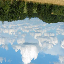

In [41]:
random_transform(X_train[1])

## Divide the data by class

<Axes: ylabel='count'>

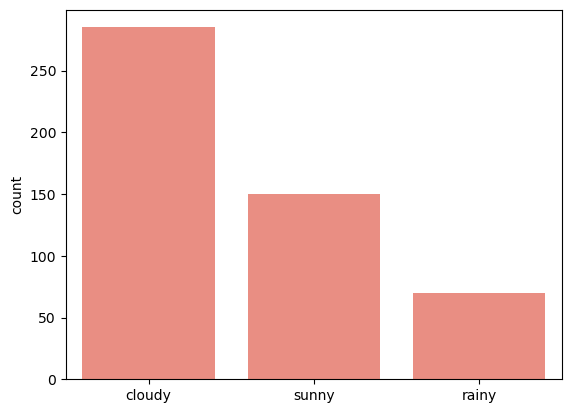

In [43]:
# Let's visualize the class balance in the training data set


sns.countplot(x=y_pre_NN,color='salmon')

In [90]:
# Let's define a function that takes in the list of training images and labels and returns them class-wise

# Define a function that takes in the list of training images and returns them class-wise
def divide_data_by_class(input_images = None, image_labels = None):
    '''
    Divides the input images and labels into subsets based on their corresponding class labels.

    Args:
        input_images: A list of input images to be divided based on class 
            labels. Each input image must be a PIL image.
        image_labels: A list that contains corresponding labels for each 
            image in input_images. Each label is a string.

    Returns:
        classwise_images: A list of lists, where each sublist contains the 
            input images corresponding to a unique class label.
        classwise_labels: A list of lists, where each sublist contains the 
            labels corresponding to the input images in classwise_images list.
    '''

    ##### CODE HERE #####
    classwise_data = {}
    
    for image,label in zip(input_images,image_labels):
        if label in classwise_data:
            classwise_data[label][0].append(image)
            classwise_data[label][1].append(label)
        else:
            classwise_data[label] = [ [image], [label] ]
            
    classwise_images = [classwise_data[label][0] for label in classwise_data]
    classwise_labels = [classwise_data[label][1] for label in classwise_data]
    return classwise_images, classwise_labels

In [92]:
divide_data_by_class(X_pre_NN,y_pre_NN)

([[<PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=64x64>,
   <PIL.Image.Image image mode=RGB size=

## Augment the training data

In [97]:
# Let's define a function that augments the training data

import random 


def augment_data(input_images, image_labels, data_size_factor):
    '''
    Augments the training data by randomly applying data augmentation techniques.

    Args:
        input_images: A list of input images.
        image_labels: A list of labels for the input images.
        data_size_factor: A scaling factor for the size of the augmented data.
            This will be used to calculate the final size of each class by 
            multiplying data_size_factor with the size of the largest class and 
            then rounding to the nearest integer.

    Returns:
        new_images: The augmented images
        new_labels: The labels corresponding to the new images
    '''
    # Divide the input data into different classes
    classwise_images, classwise_labels = divide_data_by_class(input_images, image_labels)

    # Calculate the target size for each class
    target_size = int(round(data_size_factor * max(len(images) for images in classwise_images)))

    # Augment each class separately
    new_images = []
    new_labels = []

    for images, labels in zip(classwise_images, classwise_labels):
        num_images = len(images)

        # Determine the number of new images needed
        num_new_images = target_size - num_images

        if num_new_images > 0:
            # Augment the class until the target size is reached
            while len(images) < target_size:
                # Select a random image from the original data set
                image_index = random.randint(0, num_images - 1)

                # Get the image and its label for augmentation
                image = images[image_index]
                label = labels[image_index]

                # Apply a random transformation to the image
                augmented_image = random_transform(image)

                # Add the augmented image and its label to the augmented data
                new_images.append(augmented_image)
                new_labels.append(label)

                # Add the augmented image to the class for further augmentation
                images.append(augmented_image)
                labels.append(label)

        # Add random images from the class to balance the sizes
        while len(images) > target_size:
            # Select a random image index from the class
            image_index = random.randint(0, num_images - 1)

            # Remove the image and its label from the class
            removed_image = images.pop(image_index)
            removed_label = labels.pop(image_index)
            num_images -= 1

            # Add the removed image and label to the augmented data
            new_images.append(removed_image)
            new_labels.append(removed_label)

    # Combine the original and augmented images and labels
    new_images.extend(input_images)
    new_labels.extend(image_labels)
    
    new_images = np.array(new_images)
    new_labels = np.array(new_labels)

    return new_images, new_labels


In [99]:
# Let's augment our training data


X_train, y_train = augment_data(X_pre_NN,y_pre_NN,4)

In [101]:
print(len(y_train))

3420


<Axes: ylabel='count'>

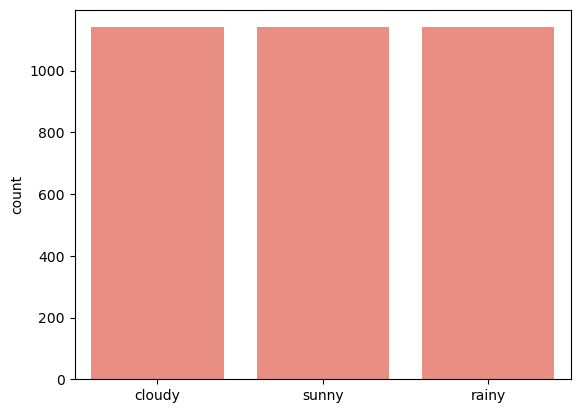

In [105]:
# Let's visualize the class balance in the training data set

##### CODE HERE #####
sns.countplot(x=y_train,color='salmon')

## Create a simple CNN model using the augmented data and analyze its performance

In [108]:
# Let's convert the training images into arrays


X_train = np.array([img_to_array(image) for image in X_train])

In [110]:
# Let's rescale the training images from the range [0, 255] to [0, 1]
X_train = X_train.astype('float32') / 255 

X_train.shape

(3420, 64, 64, 3)

In [112]:
# Let's one-hot encode the labels in the training data set

##### CODE HERE #####
y_train = to_categorical(LabelEncoder().fit_transform(y_train))
y_train.shape

(3420, 3)

In [114]:
num_trials = 10
performance_df = pd.DataFrame(columns=['Trial Number', 'Training Accuracy', 'Validation Accuracy'])

for trial in range(num_trials):
  local_df = pd.DataFrame()
  print(f"Trial {trial}")
  cnn = create_cnn(config,learning_rate_value=0.01)
  cnn.summary()
  print('\n')
  cnn_history = cnn.fit(X_train, y_train, validation_split = val_split, epochs = n_epochs)
  training_accuracy = cnn_history.history['accuracy'][-1]
  validation_accuracy = cnn_history.history['val_accuracy'][-1]
  trial_results = pd.DataFrame({
    'Trial Number': [trial],
    'Training Accuracy': [training_accuracy],
    'Validation Accuracy': [validation_accuracy]
  })
  performance_df = pd.concat([performance_df,trial_results], ignore_index=True)

performance_df.set_index('Trial Number')
performance_df.loc['Mean'] = performance_df.mean()
performance_df.loc['Median'] = performance_df.median()
performance_df.loc['Max'] = performance_df.max()
performance_df.drop(columns='Trial Number',inplace=True)
performance_df = performance_df.round(3)


Trial 0


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5173 - loss: 11.1551 - val_accuracy: 0.7617 - val_loss: 0.6449
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9076 - loss: 0.2738 - val_accuracy: 0.8012 - val_loss: 0.5370
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9512 - loss: 0.1613 - val_accuracy: 0.8216 - val_loss: 0.4585
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9761 - loss: 0.0780 - val_accuracy: 0.8289 - val_loss: 0.5955
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9919 - loss: 0.0411 - val_accuracy: 0.8070 - val_loss: 0.6123
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9977 - loss: 0.0214 - val_accuracy: 0.8377 - val_loss: 0.6432
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9989 - loss: 0.0086 - val_accuracy: 0.8260 - val_loss: 0.6069
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8231 

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5787 - loss: 3.4505 - val_accuracy: 0.7763 - val_loss: 0.5583
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8766 - loss: 0.3412 - val_accuracy: 0.7997 - val_loss: 0.4935
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9473 - loss: 0.1654 - val_accuracy: 0.7675 - val_loss: 0.7840
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9467 - loss: 0.1705 - val_accuracy: 0.7719 - val_loss: 0.5883
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9751 - loss: 0.0698 - val_accuracy: 0.8319 - val_loss: 0.5792
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9779 - loss: 0.0735 - val_accuracy: 0.8231 - val_loss: 0.6289
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9789 - loss: 0.0930 - val_accuracy: 0.8012 - val_loss: 0.8737
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9894 - loss: 0.0305 - val_accuracy: 0.8392 -

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4804 - loss: 6.8079 - val_accuracy: 0.6360 - val_loss: 0.8120
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7861 - loss: 0.5416 - val_accuracy: 0.7792 - val_loss: 0.5308
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8941 - loss: 0.3138 - val_accuracy: 0.8099 - val_loss: 0.5738
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9561 - loss: 0.1588 - val_accuracy: 0.7149 - val_loss: 0.8470
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9684 - loss: 0.1218 - val_accuracy: 0.8041 - val_loss: 0.6799
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9718 - loss: 0.0895 - val_accuracy: 0.8260 - val_loss: 0.7723
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9827 - loss: 0.0579 - val_accuracy: 0.8289 - val_loss: 0.8406
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9705 - loss: 0.0934 - val_accuracy: 0.8143 -

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5473 - loss: 9.6844 - val_accuracy: 0.7471 - val_loss: 0.6394
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9151 - loss: 0.2452 - val_accuracy: 0.8158 - val_loss: 0.6056
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9731 - loss: 0.1010 - val_accuracy: 0.8099 - val_loss: 0.5502
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9906 - loss: 0.0431 - val_accuracy: 0.8129 - val_loss: 0.6284
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9985 - loss: 0.0144 - val_accuracy: 0.7982 - val_loss: 0.7410
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8056 - val_loss: 0.8094
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.8143 - val_loss: 0.8100
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8114 -

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5618 - loss: 10.9591 - val_accuracy: 0.7617 - val_loss: 0.6640
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9018 - loss: 0.2899 - val_accuracy: 0.6944 - val_loss: 0.9200
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9608 - loss: 0.1361 - val_accuracy: 0.7792 - val_loss: 0.6988
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9899 - loss: 0.0478 - val_accuracy: 0.7822 - val_loss: 0.7918
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9974 - loss: 0.0217 - val_accuracy: 0.7909 - val_loss: 0.8230
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9991 - loss: 0.0074 - val_accuracy: 0.7442 - val_loss: 1.0088
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.7865 - val_loss: 0.8993
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.7924 

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4308 - loss: 10.1524 - val_accuracy: 0.7588 - val_loss: 0.6495
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7830 - loss: 0.5466 - val_accuracy: 0.5175 - val_loss: 1.3306
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7630 - loss: 0.5848 - val_accuracy: 0.7237 - val_loss: 0.8479
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8546 - loss: 0.3711 - val_accuracy: 0.8099 - val_loss: 0.5902
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9501 - loss: 0.1731 - val_accuracy: 0.7953 - val_loss: 0.6567
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9493 - loss: 0.1658 - val_accuracy: 0.7749 - val_loss: 0.6380
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9827 - loss: 0.0689 - val_accuracy: 0.8129 - val_loss: 0.5901
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9911 - loss: 0.0435 - val_accuracy: 0.8216 

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4104 - loss: 28.6389 - val_accuracy: 0.5994 - val_loss: 0.8769
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7870 - loss: 0.5227 - val_accuracy: 0.7924 - val_loss: 0.5502
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9053 - loss: 0.2901 - val_accuracy: 0.8304 - val_loss: 0.5008
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9601 - loss: 0.1566 - val_accuracy: 0.8319 - val_loss: 0.4860
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9791 - loss: 0.0902 - val_accuracy: 0.8173 - val_loss: 0.5603
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9852 - loss: 0.0600 - val_accuracy: 0.8304 - val_loss: 0.6530
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9444 - loss: 0.1708 - val_accuracy: 0.8187 - val_loss: 0.6524
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9752 - loss: 0.0581 - val_accuracy: 0.7076 

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4521 - loss: 16.5877 - val_accuracy: 0.6462 - val_loss: 0.8508
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8456 - loss: 0.4134 - val_accuracy: 0.7339 - val_loss: 0.7626
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9307 - loss: 0.2276 - val_accuracy: 0.7851 - val_loss: 0.6402
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9813 - loss: 0.0818 - val_accuracy: 0.7939 - val_loss: 0.6895
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9974 - loss: 0.0343 - val_accuracy: 0.7836 - val_loss: 0.8064
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9955 - loss: 0.0264 - val_accuracy: 0.7982 - val_loss: 0.7857
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9998 - loss: 0.0097 - val_accuracy: 0.8012 - val_loss: 0.8209
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.8070 

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5206 - loss: 2.4692 - val_accuracy: 0.7442 - val_loss: 0.7333
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8385 - loss: 0.4583 - val_accuracy: 0.8173 - val_loss: 0.5805
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9395 - loss: 0.1864 - val_accuracy: 0.8450 - val_loss: 0.4768
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9641 - loss: 0.1169 - val_accuracy: 0.8333 - val_loss: 0.7505
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9704 - loss: 0.0797 - val_accuracy: 0.8494 - val_loss: 0.7034
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9669 - loss: 0.1042 - val_accuracy: 0.8333 - val_loss: 0.7011
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9867 - loss: 0.0492 - val_accuracy: 0.8216 - val_loss: 0.9998
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9851 - loss: 0.0465 - val_accuracy: 0.8319 -

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 62, 62, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 61, 61, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 59, 59, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 58, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,015 (6.57 MB)

 Trainable params: 1,723,015 (6.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4466 - loss: 26.9553 - val_accuracy: 0.7061 - val_loss: 0.9304
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8024 - loss: 0.5114 - val_accuracy: 0.7105 - val_loss: 0.7824
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8724 - loss: 0.3569 - val_accuracy: 0.7997 - val_loss: 0.5494
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9074 - loss: 0.2801 - val_accuracy: 0.7398 - val_loss: 0.7004
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9208 - loss: 0.2501 - val_accuracy: 0.8231 - val_loss: 0.4779
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9297 - loss: 0.2170 - val_accuracy: 0.8260 - val_loss: 0.4969
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9730 - loss: 0.0989 - val_accuracy: 0.8363 - val_loss: 0.4254
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9819 - loss: 0.0640 - val_accuracy: 0.8509 

In [116]:
performance_df

,Training Accuracy,Validation Accuracy
0,1.000,0.823
1,0.817,0.421
2,0.984,0.779
3,1.000,0.819
4,1.000,0.791
5,0.994,0.823
6,0.984,0.781
7,1.000,0.803
8,0.738,0.417
9,0.993,0.841


We should be able to observe, from the performance data frame, that the basic CNN model that is trained on the augmented data performs better, in general than the basic CNN model that you trained earlier.

# Optimal Model
we will train your CNN model on the augmented data set and tune it for network structure and learning rate.

In [121]:
# Let's tune your CNN model for network structure and learning rate
from tensorflow.keras.backend import count_params


##### CODE HERE #####
layers_config_list = [
  ['c_2_3_1','m_2_1','c_4_3_1','d_8'],
  ['c_3_2_2','m_3_1','c_2_2_2','d_4'],
  ['c_4_2_1','m_2_2','c_3_4_4','d_6'],
  ['c_4_5_2','m_3_1','c_3_3_3','d_10'],
]
learning_rate_list = [0.01,0.001,0.0001]
performance_df = pd.DataFrame()
optimal_layer_config = None
optimal_learning_rate = None
best_val_acc = 0.0



for config in layers_config_list:
  for rate in learning_rate_list:
    cnn = create_cnn(config,learning_rate_value=rate)
    # We are going to count the number of parameters
    trainable_params = np.sum([count_params(x) for x in cnn.trainable_weights])
    
    if trainable_params <= 500000:
        cnn.summary()
        print('\n')
        cnn_history = cnn.fit(X_train, y_train, validation_split = val_split, epochs = n_epochs)
        # Record the performance
        train_acc = cnn_history.history['accuracy'][-1]
        val_acc = cnn_history.history['val_accuracy'][-1]
        trial_result_df = pd.DataFrame({
            'Network Config': str(config), 
            'Trainable parameters' : trainable_params,
            'Learning Rate': rate, 
            'Training Accuracy': train_acc, 
            'Validation Accuracy': val_acc
          },index=[0])
        
        performance_df = pd.concat([performance_df,trial_result_df],ignore_index=True)
        if val_acc > best_val_acc:
          best_val_acc = val_acc
          optimal_layer_config = config
          optimal_learning_rate = rate
      
mean_row = {
  'Network Config': 'Mean',
  'Trainable parameters' : "",
  'Learning Rate': performance_df['Learning Rate'].mean(),
  'Training Accuracy': performance_df['Training Accuracy'].mean(),
  'Validation Accuracy': performance_df['Validation Accuracy'].mean()
}

median_row = {
  'Network Config': 'Median',
  'Trainable parameters' : "",
  'Learning Rate': performance_df['Learning Rate'].median(),
  'Training Accuracy': performance_df['Training Accuracy'].median(),
  'Validation Accuracy': performance_df['Validation Accuracy'].median()
}

max_row = {
  'Network Config': 'Max',
  'Trainable parameters' : "",
  'Learning Rate': performance_df['Learning Rate'].max(),
  'Training Accuracy': performance_df['Training Accuracy'].max(),
  'Validation Accuracy': performance_df['Validation Accuracy'].max()
}

performance_df = pd.concat([performance_df, pd.DataFrame([mean_row, median_row, max_row])], ignore_index=True)



Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 32, 32, 3)      │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 15, 15, 2)      │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 13, 13, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 338)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        43,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,844 (171.27 KB)

 Trainable params: 43,844 (171.27 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5214 - loss: 1.5292 - val_accuracy: 0.6564 - val_loss: 0.7565
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7129 - loss: 0.6684 - val_accuracy: 0.6535 - val_loss: 0.8435
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7561 - loss: 0.5661 - val_accuracy: 0.7500 - val_loss: 0.5517
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8022 - loss: 0.4753 - val_accuracy: 0.6915 - val_loss: 0.7472
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8053 - loss: 0.4858 - val_accuracy: 0.8085 - val_loss: 0.4956
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8830 - loss: 0.3069 - val_accuracy: 0.8480 - val_loss: 0.4581
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8828 - loss: 0.3235 - val_accuracy: 0.7237 - val_loss: 0.6873
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9025 - loss: 0.2671 - val_accuracy: 0.8553 - val_los

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 3)      │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 15, 15, 2)      │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 13, 13, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 338)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │        43,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,844 (171.27 KB)

 Trainable params: 43,844 (171.27 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4840 - loss: 0.9916 - val_accuracy: 0.6038 - val_loss: 0.8308
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7016 - loss: 0.6750 - val_accuracy: 0.6725 - val_loss: 0.7218
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7550 - loss: 0.5750 - val_accuracy: 0.7412 - val_loss: 0.6186
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8078 - loss: 0.4778 - val_accuracy: 0.7500 - val_loss: 0.5938
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8162 - loss: 0.4309 - val_accuracy: 0.7047 - val_loss: 0.6603
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8439 - loss: 0.3806 - val_accuracy: 0.7661 - val_loss: 0.5820
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8553 - loss: 0.3375 - val_accuracy: 0.7909 - val_loss: 0.5359
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8880 - loss: 0.3034 - val_accuracy: 0.8041 - val_los

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 32, 32, 3)      │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 15, 15, 2)      │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 13, 13, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 338)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        43,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,844 (171.27 KB)

 Trainable params: 43,844 (171.27 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3552 - loss: 1.1061 - val_accuracy: 0.2880 - val_loss: 1.1244
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3951 - loss: 1.0419 - val_accuracy: 0.3494 - val_loss: 1.0872
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4778 - loss: 1.0008 - val_accuracy: 0.4152 - val_loss: 1.0572
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5535 - loss: 0.9610 - val_accuracy: 0.4503 - val_loss: 1.0145
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5617 - loss: 0.9199 - val_accuracy: 0.4825 - val_loss: 0.9731
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5784 - loss: 0.9046 - val_accuracy: 0.4825 - val_loss: 0.9810
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.8457 - val_accuracy: 0.4883 - val_loss: 0.9567
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6124 - loss: 0.8318 - val_accuracy: 0.4985 - val_los

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 63, 63, 4)      │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 31, 31, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 7, 7, 3)        │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 3, 3, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218 (16.48 KB)

 Trainable params: 4,218 (16.48 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5832 - loss: 0.8385 - val_accuracy: 0.7442 - val_loss: 0.6339
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8276 - loss: 0.4640 - val_accuracy: 0.8231 - val_loss: 0.4712
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8774 - loss: 0.3451 - val_accuracy: 0.7675 - val_loss: 0.6085
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8713 - loss: 0.3432 - val_accuracy: 0.8377 - val_loss: 0.3862
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9086 - loss: 0.2538 - val_accuracy: 0.8406 - val_loss: 0.4159
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9093 - loss: 0.2556 - val_accuracy: 0.8801 - val_loss: 0.3444
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9286 - loss: 0.1977 - val_accuracy: 0.8392 - val_loss: 0.4595
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9296 - loss: 0.2013 - val_accuracy: 0.8962 - val_los

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 63, 63, 4)      │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 31, 31, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 7, 7, 3)        │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 3, 3, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218 (16.48 KB)

 Trainable params: 4,218 (16.48 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4413 - loss: 1.0368 - val_accuracy: 0.5424 - val_loss: 0.9437
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6153 - loss: 0.7973 - val_accuracy: 0.5629 - val_loss: 0.8707
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6460 - loss: 0.7589 - val_accuracy: 0.5307 - val_loss: 0.9004
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6605 - loss: 0.7247 - val_accuracy: 0.6053 - val_loss: 0.8019
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6728 - loss: 0.6782 - val_accuracy: 0.5570 - val_loss: 0.7920
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6977 - loss: 0.6684 - val_accuracy: 0.5731 - val_loss: 0.8048
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7210 - loss: 0.6268 - val_accuracy: 0.6184 - val_loss: 0.7564
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7561 - loss: 0.5924 - val_accuracy: 0.6330 - val_los

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 63, 63, 4)      │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 31, 31, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 7, 7, 3)        │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 3, 3, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218 (16.48 KB)

 Trainable params: 4,218 (16.48 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3422 - loss: 1.0877 - val_accuracy: 0.2544 - val_loss: 1.0975
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3745 - loss: 1.0398 - val_accuracy: 0.2909 - val_loss: 1.0783
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4234 - loss: 0.9954 - val_accuracy: 0.3611 - val_loss: 1.0518
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5191 - loss: 0.9622 - val_accuracy: 0.4635 - val_loss: 1.0146
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5561 - loss: 0.9303 - val_accuracy: 0.5687 - val_loss: 0.9762
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6416 - loss: 0.8869 - val_accuracy: 0.6287 - val_loss: 0.9384
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6775 - loss: 0.8536 - val_accuracy: 0.6623 - val_loss: 0.8982
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7135 - loss: 0.8166 - val_accuracy: 0.6652 - val_los

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 30, 30, 4)      │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 28, 28, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 9, 9, 3)        │           111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 7, 7, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 147)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,746 (77.13 KB)

 Trainable params: 19,746 (77.13 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4513 - loss: 1.1345 - val_accuracy: 0.6433 - val_loss: 0.7885
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7099 - loss: 0.6653 - val_accuracy: 0.8114 - val_loss: 0.5617
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8273 - loss: 0.4487 - val_accuracy: 0.7909 - val_loss: 0.6435
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6782 - loss: 0.8899 - val_accuracy: 0.8056 - val_loss: 0.4810
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8580 - loss: 0.3821 - val_accuracy: 0.8275 - val_loss: 0.5375
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8743 - loss: 0.3292 - val_accuracy: 0.8860 - val_loss: 0.4056
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8638 - loss: 0.3754 - val_accuracy: 0.9035 - val_loss: 0.3644
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9269 - loss: 0.2206 - val_accuracy: 0.7939 - val_los

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 30, 30, 4)      │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 28, 28, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 9, 9, 3)        │           111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 7, 7, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 147)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,746 (77.13 KB)

 Trainable params: 19,746 (77.13 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6340 - loss: 0.8233 - val_accuracy: 0.7953 - val_loss: 0.5498
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8378 - loss: 0.4578 - val_accuracy: 0.8319 - val_loss: 0.4557
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8631 - loss: 0.3762 - val_accuracy: 0.8465 - val_loss: 0.4196
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8763 - loss: 0.3274 - val_accuracy: 0.7924 - val_loss: 0.5214
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8770 - loss: 0.3135 - val_accuracy: 0.8713 - val_loss: 0.3854
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8843 - loss: 0.2994 - val_accuracy: 0.8611 - val_loss: 0.3823
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9113 - loss: 0.2616 - val_accuracy: 0.8728 - val_loss: 0.3660
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9314 - loss: 0.2170 - val_accuracy: 0.8757 - val_los

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 30, 30, 4)      │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 28, 28, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 9, 9, 3)        │           111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 7, 7, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 147)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,746 (77.13 KB)

 Trainable params: 19,746 (77.13 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4436 - loss: 1.0330 - val_accuracy: 0.4020 - val_loss: 1.0008
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5547 - loss: 0.9129 - val_accuracy: 0.5819 - val_loss: 0.9044
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6373 - loss: 0.8231 - val_accuracy: 0.6535 - val_loss: 0.8297
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7213 - loss: 0.7351 - val_accuracy: 0.7135 - val_loss: 0.7472
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7521 - loss: 0.6582 - val_accuracy: 0.7135 - val_loss: 0.7147
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7764 - loss: 0.6140 - val_accuracy: 0.7368 - val_loss: 0.6637
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7865 - loss: 0.5916 - val_accuracy: 0.7471 - val_loss: 0.6341
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7980 - loss: 0.5474 - val_accuracy: 0.7588 - val_los

In [123]:
# Let's find the optimal configuration with the highest validation accuracy
print(performance_df)

                             Network Config Trainable parameters  \
0    ['c_3_2_2', 'm_3_1', 'c_2_2_2', 'd_4']                43844   
1    ['c_3_2_2', 'm_3_1', 'c_2_2_2', 'd_4']                43844   
2    ['c_3_2_2', 'm_3_1', 'c_2_2_2', 'd_4']                43844   
3    ['c_4_2_1', 'm_2_2', 'c_3_4_4', 'd_6']                 4218   
4    ['c_4_2_1', 'm_2_2', 'c_3_4_4', 'd_6']                 4218   
5    ['c_4_2_1', 'm_2_2', 'c_3_4_4', 'd_6']                 4218   
6   ['c_4_5_2', 'm_3_1', 'c_3_3_3', 'd_10']                19746   
7   ['c_4_5_2', 'm_3_1', 'c_3_3_3', 'd_10']                19746   
8   ['c_4_5_2', 'm_3_1', 'c_3_3_3', 'd_10']                19746   
9                                      Mean                        
10                                   Median                        
11                                      Max                        

    Learning Rate  Training Accuracy  Validation Accuracy  
0          0.0100           0.948099             0.8260

In [125]:
# Let's specify our optimal hyperparameter values
optimal_layer_config =  optimal_layer_config
optimal_learning_rate = optimal_learning_rate

In [127]:
print("Optimal Layer Configuration:", optimal_layer_config)
print("Optimal Learning Rate:", optimal_learning_rate)

Optimal Layer Configuration: ['c_4_5_2', 'm_3_1', 'c_3_3_3', 'd_10']
Optimal Learning Rate: 0.01


## Train our optimal model satisfactorily

In [130]:
# Let's train our optimal model on the augment data set until we are satisfied with its validation performance


cnn = create_cnn(optimal_layer_config,learning_rate_value= optimal_learning_rate)
cnn.summary()
cnn_history = cnn.fit(X_train, y_train, validation_split = val_split, epochs = n_epochs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)              │ (None, 30, 30, 4)      │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 28, 28, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 9, 9, 3)        │           111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 7, 7, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 147)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,746 (77.13 KB)

 Trainable params: 19,746 (77.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4314 - loss: 1.0994 - val_accuracy: 0.5541 - val_loss: 0.8120
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7361 - loss: 0.6349 - val_accuracy: 0.7982 - val_loss: 0.5554
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8483 - loss: 0.4340 - val_accuracy: 0.6871 - val_loss: 0.7807
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7762 - loss: 0.5616 - val_accuracy: 0.6243 - val_loss: 0.8137
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7840 - loss: 0.5000 - val_accuracy: 0.7105 - val_loss: 0.7880
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8728 - loss: 0.3136 - val_accuracy: 0.8699 - val_loss: 0.4179
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9238 - loss: 0.2278 - val_accuracy: 0.7485 - val_loss: 0.7016
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8718 - loss: 0.3338 - val_accuracy: 0.8363 - val_loss:

In [132]:
# Let's test our optimal model on the hold-out test data set


performance_test = cnn.evaluate(X_test, y_test)

print('The accuracy of the model on the testing data is {}'.format(performance_test[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8146 - loss: 0.5668
The accuracy of the model on the testing data is 0.800000011920929
